# Final Project Part 2
##### NumPDE

__Devon Kesseli__

December 18th, 2018



## 1D time-dependent freeze PDE

At some point I realised that becoming a proficient Firedrake user over the course of this project was a bit naive.  After spending a long time getting it running, doing a few tutorials, and attempting to manipulate the demo problem to do what I wanted, I had to come to terms with the fact that it wasn't all going to work.  I decided to do a supplemental finite difference test to look at some of the phase-change phenomena I wasn't going to be able to capture in Firedrake. 

Here, I use the trasient FD tools from the class notebooks.  It's essentially the transient diffusion solver, with a slight twist.  I'm incuding a phase change, in 1D, with an associated latent heat.  This is a pretty unsophisticated implementation, but essentially I have the rate of heat transfer determented by temperature, while the temperature remains unchanged for some region of enthalpy.

This will allow me to look at time dependent melting rates for a solid in 1D. It will not capture convection like the Firedrake solver, but using both pieces together would give interesing and worthwhile results.

In [12]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

### Phase change piecewise functions

The piecewise function below converts from enthalpy to temperature.  This is plotted underneath.  The second function just calculates if the result is a solid or liquid.  For this problem everything is starting as a solid, so I can assume it remains a solid until the full latent heat is added. If both melting and freezing was happening, the second function would be more complex.  Solids are given a 0, and liquids a 1.

In [13]:
def enth_to_T(h):
    hl = (1/3)
    hs = (2/3)
    Tdif = 1.
    scale = Tdif/(hl + (1-hs))
    T = []
    for j in range(len(h)):
        if h[j] <= hl:
            T.append(h[j]*scale)
        elif h[j] > hl and h[j] <= hs:
            T.append(hl*scale)
        elif h[j] > hs:
            T.append(h[j]*scale - Tdif/2)
    return numpy.array(T)

def SorL(u):
    T = []
    for j in range(len(u)):
        if u[j] <= 0.5:
            T.append(0)
        else:
            T.append(1)
    return numpy.array(T)       

Text(0,0.5,'Temperature')

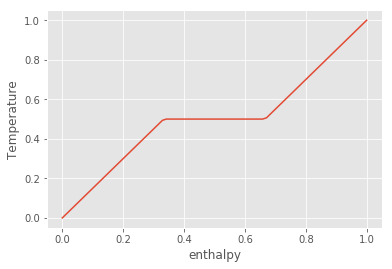

In [14]:
u = numpy.linspace(0,1,80)
T = enth_to_T(u)

pyplot.plot(u, T)
pyplot.xlabel('enthalpy')
pyplot.ylabel('Temperature')

In [15]:
##FD tools 

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

### Diffusion with the phase change equation

The diffusion equation is the same as in the class notebook, except now it involved both u (internal energy or enthalpy) and T (temperature).  

$$ \dot u(t,x) - T''(t,x) = f(t,x) \qquad t > 0, -1 < x < 1 \\ $$

Like in class, I'm using the Chebyshev discretization in space.  The only real difference here is that the Enth_to_T function I defined above is applied to u before the spacial second-derivative operator A is applied.  

At each time step, a new T is calculated at the end, as well as an array of the solid/liquid state of each point.  These results are output with the original two.

In [16]:
def dae_theta_linear(M, A, u0, rhsfunc, bcs=[], tfinal=1, h=0.1, theta=.5):
    u = u0.copy()
    t = 0
    T0 = enth_to_T(u)
    SL0 = SorL(T0)
    hist = [(t,u0,T0,SL0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        T = enth_to_T(u)    #T is calculated from u
        rhs = (M + (1-theta)*h*A) @ T + h*rhsfunc(t+theta*h) #A is applied to T, not u
        for i, f in bcs:
            rhs[i] = theta*h*f(t+theta*h, x[i])
        u = numpy.linalg.solve(M - theta*h*A, rhs)
        t = tnext
        T2 = enth_to_T(u)
        #if t == h:
        #    print(u.shape)
        #    print(T2.shape)
        SL = SorL(T)
        hist.append((t,u.copy(),T2.copy(),SL.copy()))
    return hist

In [17]:
def diffusion_cheb(n, left, right):
    """Solve the diffusion PDE on (-1,1) using n elements with rhsfunc(x) forcing.
    The left and right boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)"""
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    h = chebeval(x)
    L = -h[2]
    bcs = []
    for i,deriv,func in [(0, *left), (-1, *right)]:
        L[i] = h[deriv][i]
        bcs.append((i, func))
    M = numpy.eye(n+1)
    M[[0,-1]] = 0
    T2 = numpy.array([enth_to_T(h[0][0])])
    T = h[0]
    return x, M, -L @ numpy.linalg.inv(T), bcs

x, M, A, bcs = diffusion_cheb(200, (1, lambda t,x: 0*x), (0, lambda t,x: 0*x+1))
hist = dae_theta_linear(M, A, x*0, lambda t: 0*x, bcs,
                        h=.05, theta=1, tfinal = 1)

(201,)
(201,)


### Results!

I started with the entire system at $u = T = 0$.  The phase change occurs at $T = 0.5$.  The left side has a 0 Neumann boundary condition (representing a well insulated wall), while the other side is kept at a constant temperature of 1.  Like in class, $\theta = 1$ was necessary to get stable results.

Below are plots of u, T, and the solid-liquid interface.

Text(0,0.5,'Internal energy (u)')

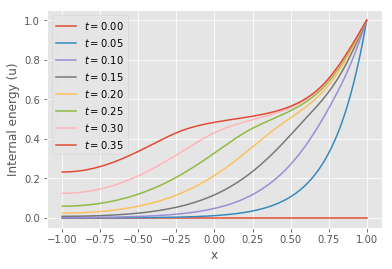

In [18]:
# u plot
for t, u, T2, SL in hist[0:8]:
    pyplot.plot(x, u, label='$t={:4.2f}$'.format(t))
pyplot.legend(loc='upper left');
pyplot.xlabel('x')
pyplot.ylabel('Internal energy (u)')

First plot seems good.  It's clear that the boundary conditions are met, and energy is diffusing left from the right Dirichlet boundary.  It makes sense that more energy is required at the interface, since it can't be heated above 0.5 until after the phase change.

At $t = \infty$ we expect the energy to become a horizontal line at $u=1$, but this could take a very long time, since the temperature gradient is small.

Text(0,0.5,'Temperature (T)')

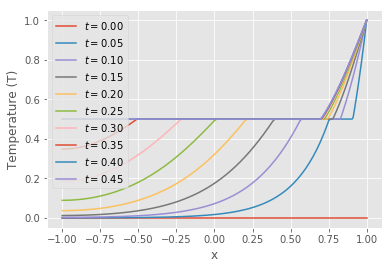

In [19]:
#T plot
for t, u,T, SL in hist[0:10]:
    pyplot.plot(x, T, label='$t={:4.2f}$'.format(t))
pyplot.legend(loc='upper left');
pyplot.xlabel('x')
pyplot.ylabel('Temperature (T)')

I think this plot is performing as expected too.  Temperature within the solid is raised up to the melting point, but can not be increased further until the interface moves left, since it is determined by $T''$. 

Text(0,0.5,'Solid (0) vs Liquid (1)')

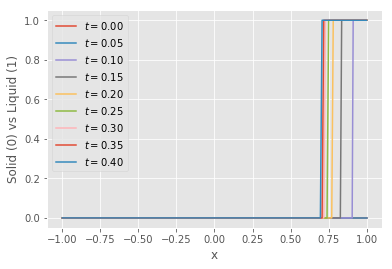

In [20]:
#SL Plot
for t, u,T, SL in hist[0:9]:
    pyplot.plot(x, SL, label='$t={:4.2f}$'.format(t))
pyplot.legend(loc='upper left');
pyplot.xlabel('x')
pyplot.ylabel('Solid (0) vs Liquid (1)')

As we can see, it is liquid on the right, and solid on the left.  The solid-liquid interface moves from right to left, but slows down as it moves away from the right boundary. 

Text(0,0.5,'Melted fraction')

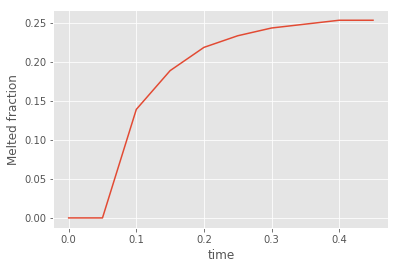

In [21]:
melt_frac = []
time = []
for t, u,T, SL in hist[0:10]:
    #print(SL[-1])
    total_spaces = len(SL)
    melted_spaces = sum(SL)
    #print(SL)
    #print(melted_spaces)
    melt_frac.append(melted_spaces/total_spaces)
    time.append(t)

#print(melt_frac)
pyplot.plot(time, melt_frac)
pyplot.xlabel('time')
pyplot.ylabel('Melted fraction')

Here, the melted fraction is plotted over time, showing a slowing (but continuously increasing) interface.